In [30]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


from htmresearch.support.autoencoder.lateral_k_sparse_autoencoder import LateralKSparseAutoencoder

params = {
    "num_inputs": 28**2,
    "num_outputs": 1000,
    "code_weight": 25,
    "learning_rate": 0.1,
    "beta": 0.001,
    "enforce_binary_output": False,
    "enable_boosting"      : True,
    "enforce_code_weight"  : True,
    "with_lateral"         : False
}

sp = LateralKSparseAutoencoder(**params)
print sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**Lateral k-sparse autoencoder:**
------------------
Number of inputs (m):	 784
Number of outputs (n):	 1000
Code weight (k):	 25
Sparsity (k/n):		 0.025
Beta:			 0.001
Learning rate:		 0.1
Min/Max weights :	 -4.47  |  +4.71
Binary outupt:		 False
Boosting:		 True
Lateral:		 False
Enforce code weight:	 True
------------------


0
1
2


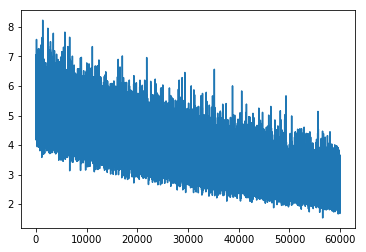

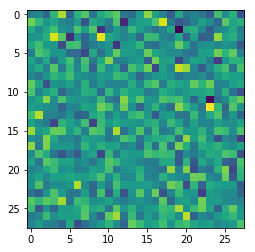

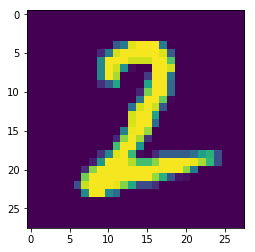

In [31]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier

mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


d = 60000
for i in range(3):
    print i
    perm = np.random.permutation(len(X_train))
    Y, E, L = sp.fit(X_train[perm][:d])

plt.plot(L)
plt.show()
plt.imshow(sp.weights[1].reshape(28,28))
plt.show()
plt.imshow(X_train[perm][0].reshape(28,28))


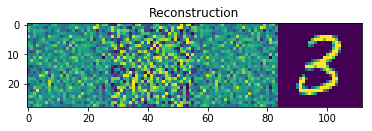

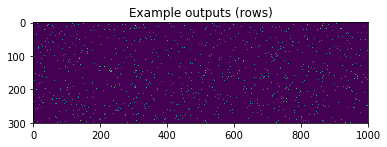

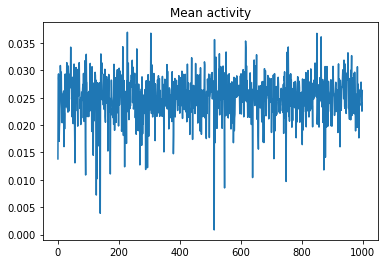

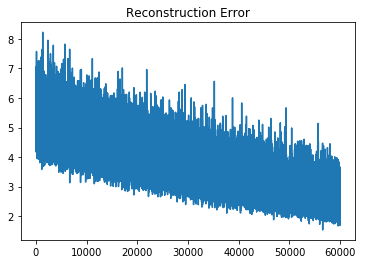

10
100
(280, 2800)


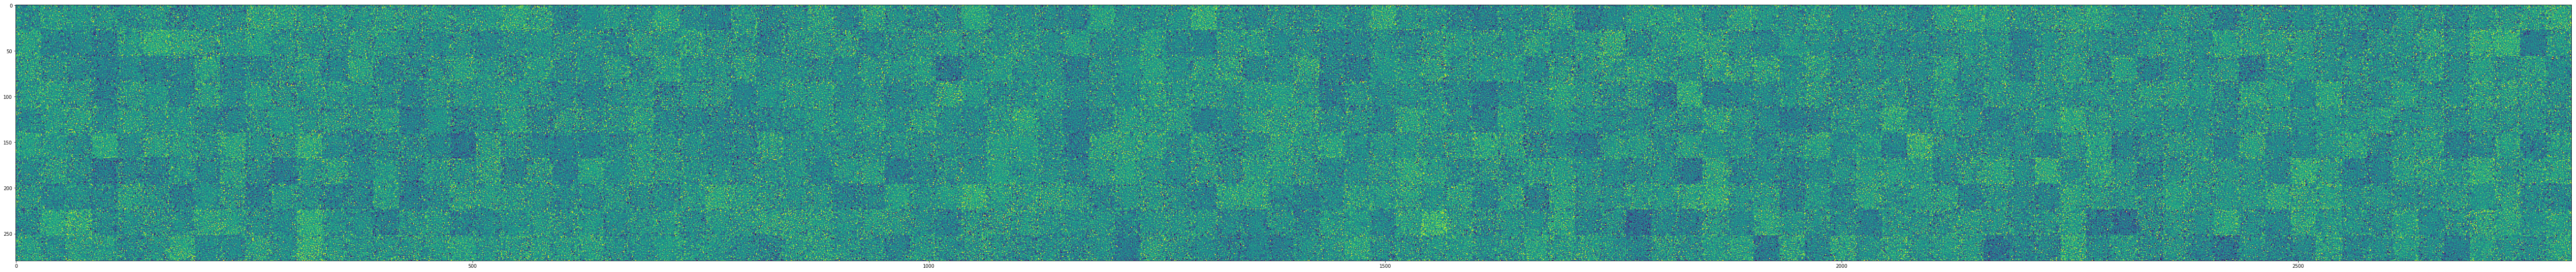

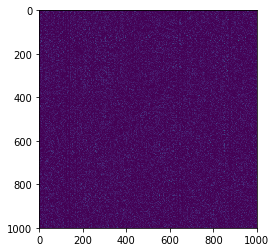

In [32]:
from scipy.special import expit as sigmoid

def normalize(x):
    x = x - np.amin(x)
    x = x/np.amax(x)
    return x

W = sp.weights
k = sp.code_weight
t=-1

x_hat = np.dot(W.T, Y[t]).reshape(28,28)
x_hat_sig = sigmoid(0.2*x_hat)
x_hat_e = np.dot(W.T, E[t]*Y[t]).reshape(28,28)
x = X_train[perm][t].reshape(28,28)

x = normalize(x)
x_hat = normalize(x_hat)
x_hat_sig = normalize(x_hat_sig)
x_hat_e = normalize(x_hat_e)
plt.title("Reconstruction")

plt.imshow(np.concatenate([x_hat, x_hat_sig, x_hat_e, x], axis=1))
plt.show()

plt.title("Example outputs (rows)")
plt.imshow(Y[:300])
plt.show()

plt.title("Mean activity")
plt.plot(sp.mean_activity)
plt.show()

plt.title("Reconstruction Error")
plt.plot(L[:])
plt.show()

f = 10
n = sp.num_outputs
W = sp.weights
img_matrix = [[ W[i*n//f + j].reshape(28,28) for j in range(n//f) ]    for i in range(f)]

img_matrix = [[ img - np.amin(img) for img in row ] for row in img_matrix ]
img_matrix = [[ img/np.amax(img) for img in row ] for row in img_matrix ]

print len(img_matrix)
print len(img_matrix[0])

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(100,10))
print img.shape
plt.imshow(img)
plt.show()
plt.imshow(sp.lateralConnections)


## 

In [33]:


per = np.random.permutation(len(X_test))
print sp


**Lateral k-sparse autoencoder:**
------------------
Number of inputs (m):	 784
Number of outputs (n):	 1000
Code weight (k):	 25
Sparsity (k/n):		 0.025
Beta:			 0.001
Learning rate:		 0.1
Min/Max weights :	 -2.76  |  +3.38
Binary outupt:		 False
Boosting:		 True
Lateral:		 False
Enforce code weight:	 True
------------------


41864.0049636
4454.85522635


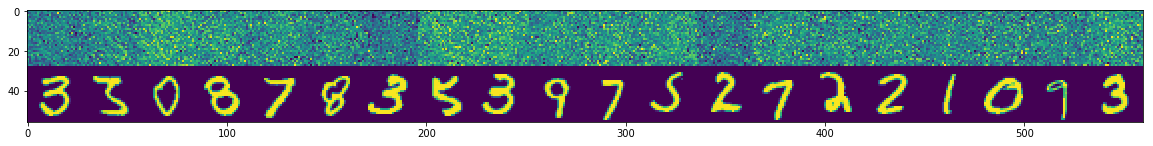

In [34]:

T = 10000
Y_test  = sp.encode(X_test[per][:T], with_boosting=True, with_lateral=True, enforce_binary_output=False)



X_hat  =  np.dot(Y_test, sp.weights)



print np.sum((X_hat[:T] - X_test[per][:T])**2)/T
print np.sum(np.abs(X_hat[:T] - X_test[per][:T]))/T


img_matrix = []
for i in range(20):
    x = normalize(X_test[per][i])
    x_hat = normalize(X_hat[i])

    
    img_matrix.append([ x_hat.reshape((28,28)).T, x.reshape((28,28)).T])

img = np.concatenate([ np.concatenate(row, axis=1) for row in img_matrix], axis=0)

plt.figure(figsize=(20,10))
plt.imshow(img.T)

In [38]:
import inspect
 
print inspect.getsource(sp._get_boostfactor)

    def _get_boostfactor(self, strength=100):
        alpha = np.clip(self.mean_activity,0.000001,1)
        boo = (1./alpha).reshape((-1,1))
        # boo = np.exp( - strength*self.mean_activity ).reshape((-1,1))
        return boo

